In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
# z=0.138673(x^2+y^2)
data = np.genfromtxt('/content/drive/MyDrive/OpScan/HexPanel03.csv', delimiter=',')
data = data[1:,:] # remove the first row

In [7]:
data, np.min(data, axis=0), np.max(data, axis=0)

(array([[  2.962981,  80.32972 , -27.665979],
        [  3.118088,  80.335052, -27.687822],
        [  3.27161 ,  80.343964, -27.714256],
        ...,
        [ 34.023872, -78.930672,   1.852535],
        [ 34.277428, -78.920387,   1.838046],
        [ 34.397747, -78.905518,   1.808588]]),
 array([-110.575417,  -78.930672,  -30.528183]),
 array([82.732468, 81.355293,  5.117711]))

In [8]:
# define the fitting function from the point cloud, with translation and rotation
def func(data, rx, ry, rz, tx, ty, tz):

    data = data + np.array([tx, ty, tz])
    # the 3D rotational
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                     [np.sin(rz), np.cos(rz), 0],
                        [0, 0, 1]])
    Ry = np.array([[np.cos(ry), 0, np.sin(ry)],
                        [0, 1, 0],
                        [-np.sin(ry), 0, np.cos(ry)]])
    Rx = np.array([[1, 0, 0],
                        [0, np.cos(rx), -np.sin(rx)],
                        [0, np.sin(rx), np.cos(rx)]])
    R = np.dot(Rz, np.dot(Ry, Rx))  # the 3D rotational matrix
    # the 3D translation vector
    T = np.array([[tx], [ty], [tz]])
    # the 3D transformation
    # each row is a point, do the matrix multiplication
    P = np.dot(R, data.T)
    P = P.T
    height = -0.001*(P[:,0]**2 + P[:,1]**2)+tz
    return height


In [9]:
# use the scipy.optimize.curve_fit to fit the data
import scipy.optimize as opt

# initial guess of the parameters
rx, ry, rz = np.pi*0, 0, 0
tx, ty, tz =  -50, 0, 0
A = 0.001
# fitting
popt, pcov = opt.curve_fit(func, data, data[:,2], p0=[rx, ry, rz, tx, ty, tz],
                           bounds= ([-np.pi/2, -np.pi/3, -np.pi/3, -np.inf, -np.inf, -100],
                                    [np.pi/2, np.pi/3, np.pi/3, np.inf, np.inf, 100]))

In [10]:
print("x-rotation (in rad): ", popt[0])
print("y-rotation (in rad): ", popt[1])
print("z-rotation (in rad): ", popt[2])
print("x-translation: ", popt[3])
print("y-translation: ", popt[4])
print("z-translation: ", popt[5])
#print("magnitude: ", popt[6])

x-rotation (in rad):  0.2257609234331721
y-rotation (in rad):  0.14334602985742678
z-rotation (in rad):  1.0471975511965972
x-translation:  20.832782277467636
y-translation:  99.17779037407301
z-translation:  5.530588007569435


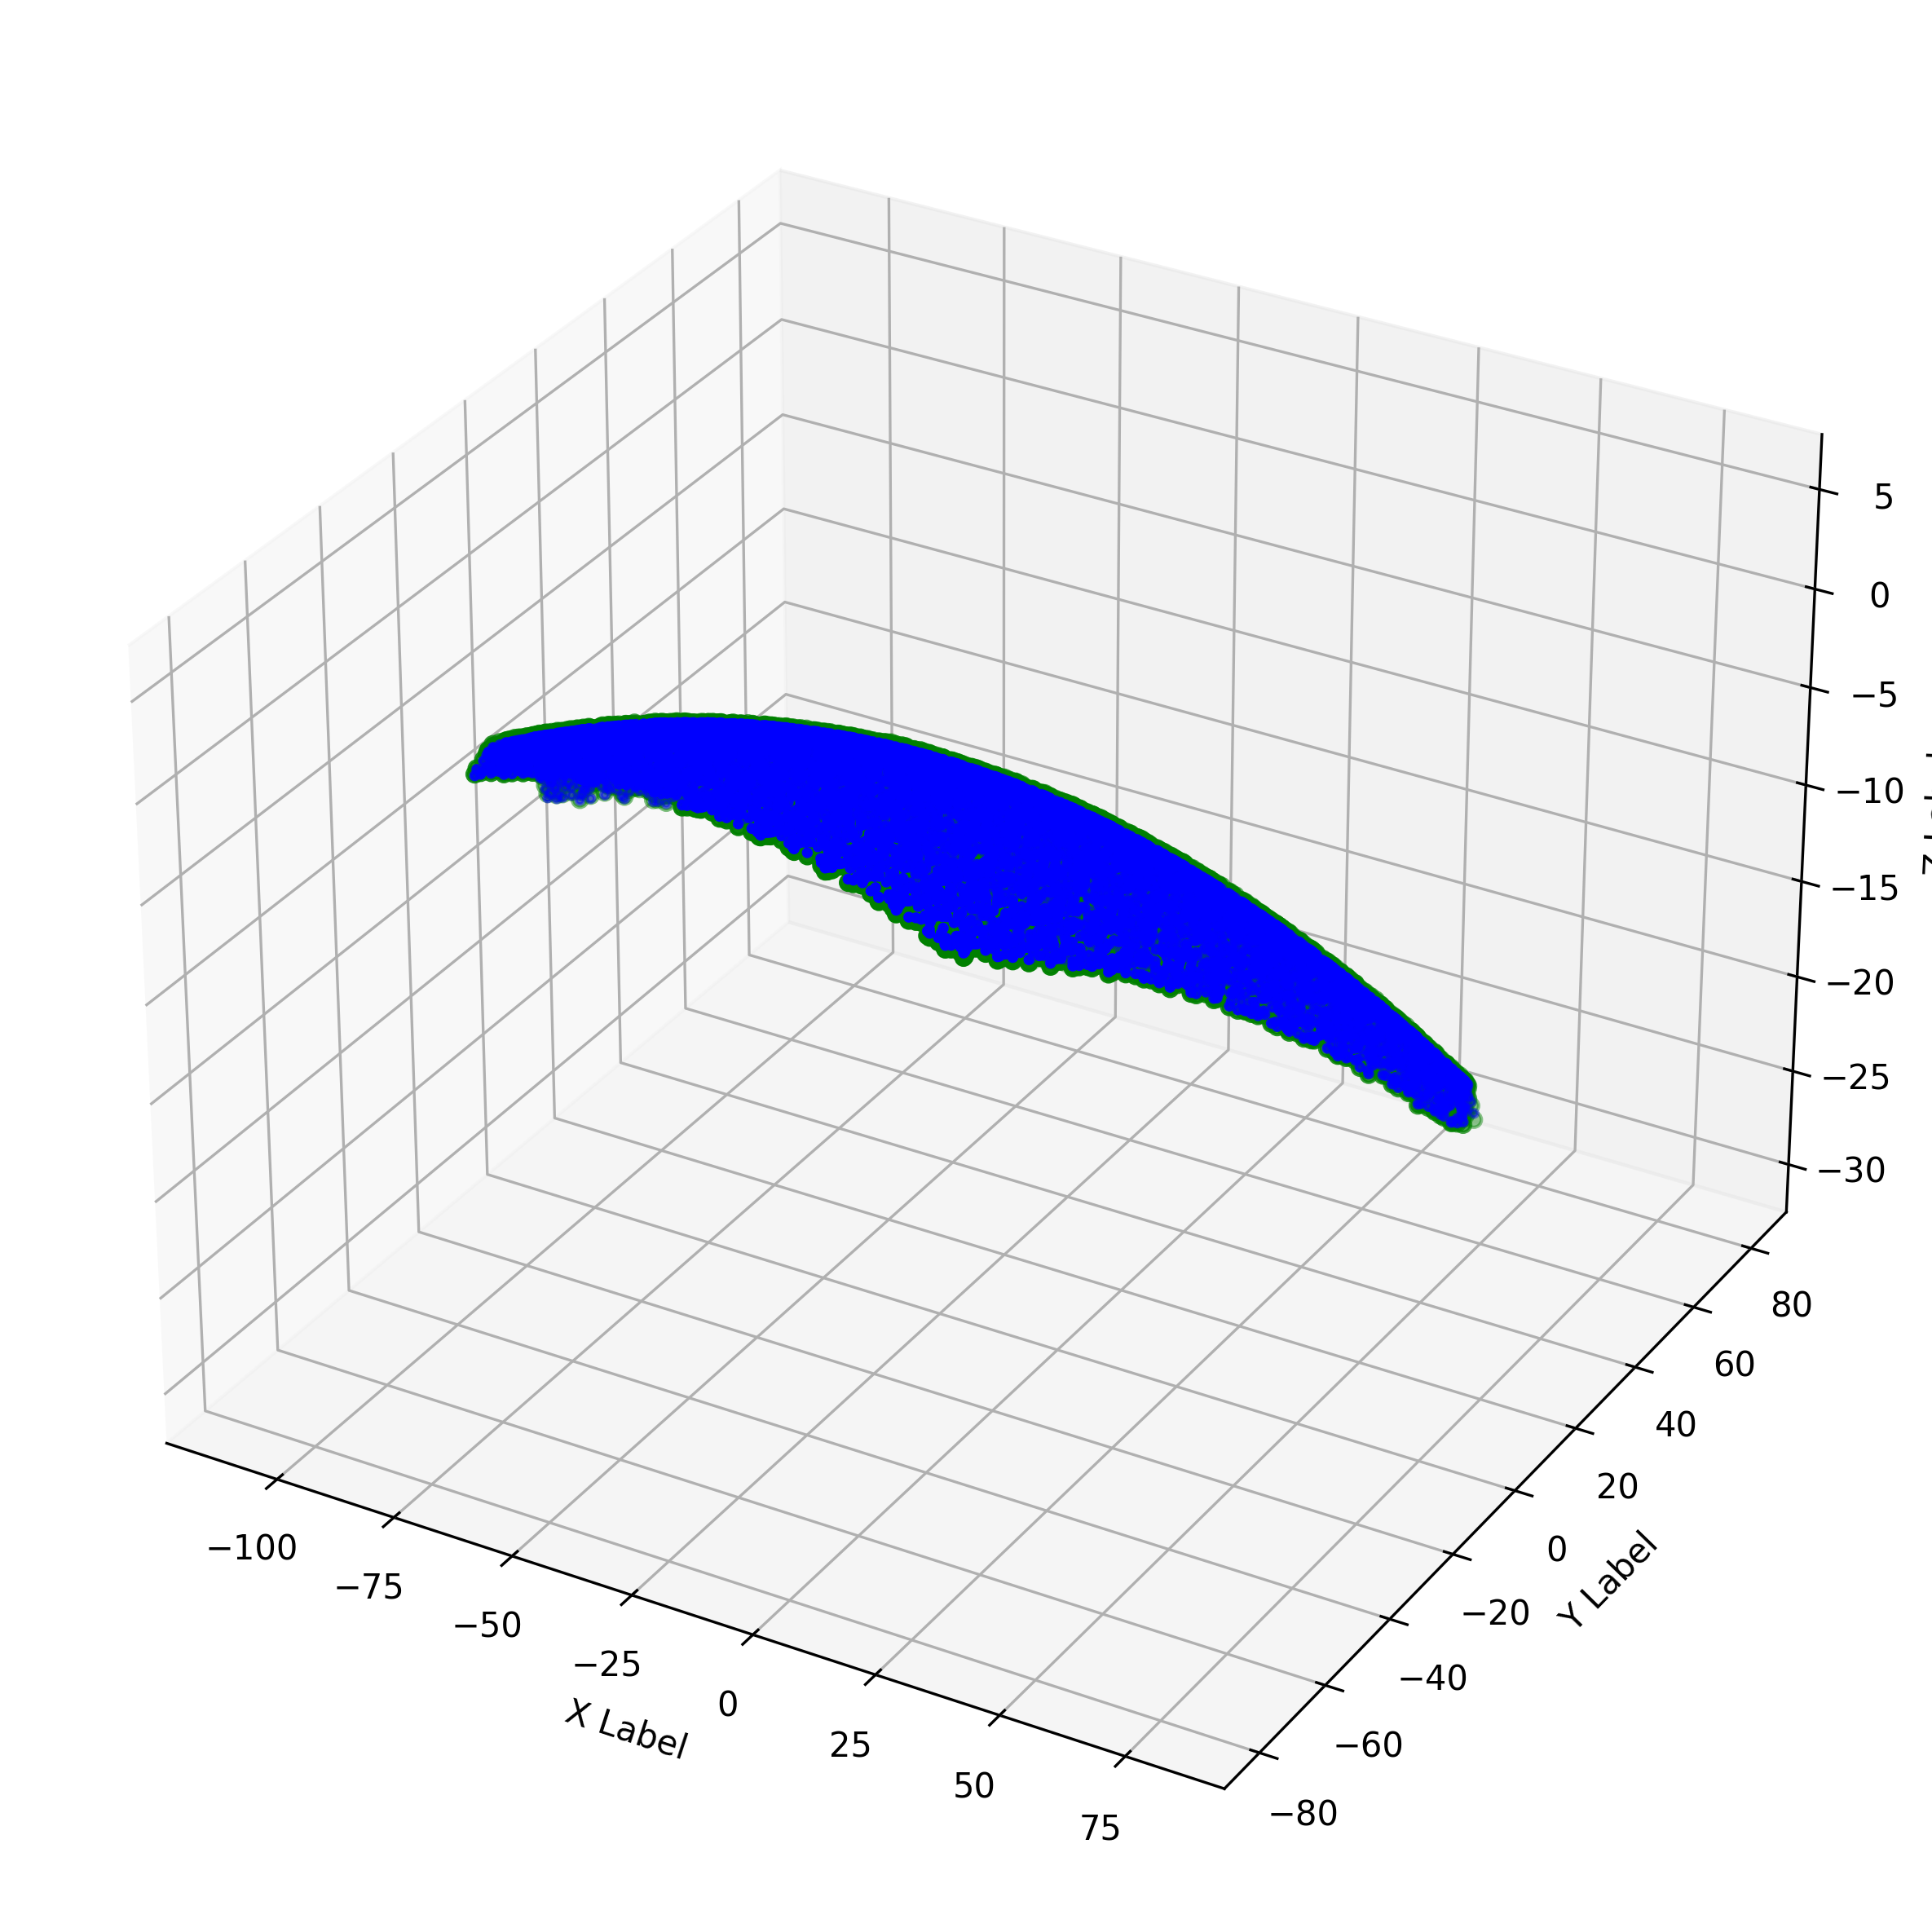

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

desample_step = 100
fig = plt.figure(figsize=(10,10), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[::desample_step,0], data[::desample_step,1], data[::desample_step,2], c='g', marker='o')
ax.scatter(data[::desample_step,0], data[::desample_step,1], func(data[::desample_step,:], *popt), c='b', marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()


In [12]:
RMSE = np.sqrt(np.mean((data[:,2]-func(data, *popt))**2))
print(f"RMSE:{RMSE}")

RMSE:0.07902866432655761


In [13]:
# 2D plot for the residual, color coded
# interpolate the data
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# define grid.
xi = np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000)
yi = np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000)
# grid the data
zi = griddata((data[:,0], data[:,1]), data[:,2]-func(data[:,:], *popt), (xi[None,:], yi[:,None]), method='linear')

<function matplotlib.pyplot.show(close=None, block=None)>

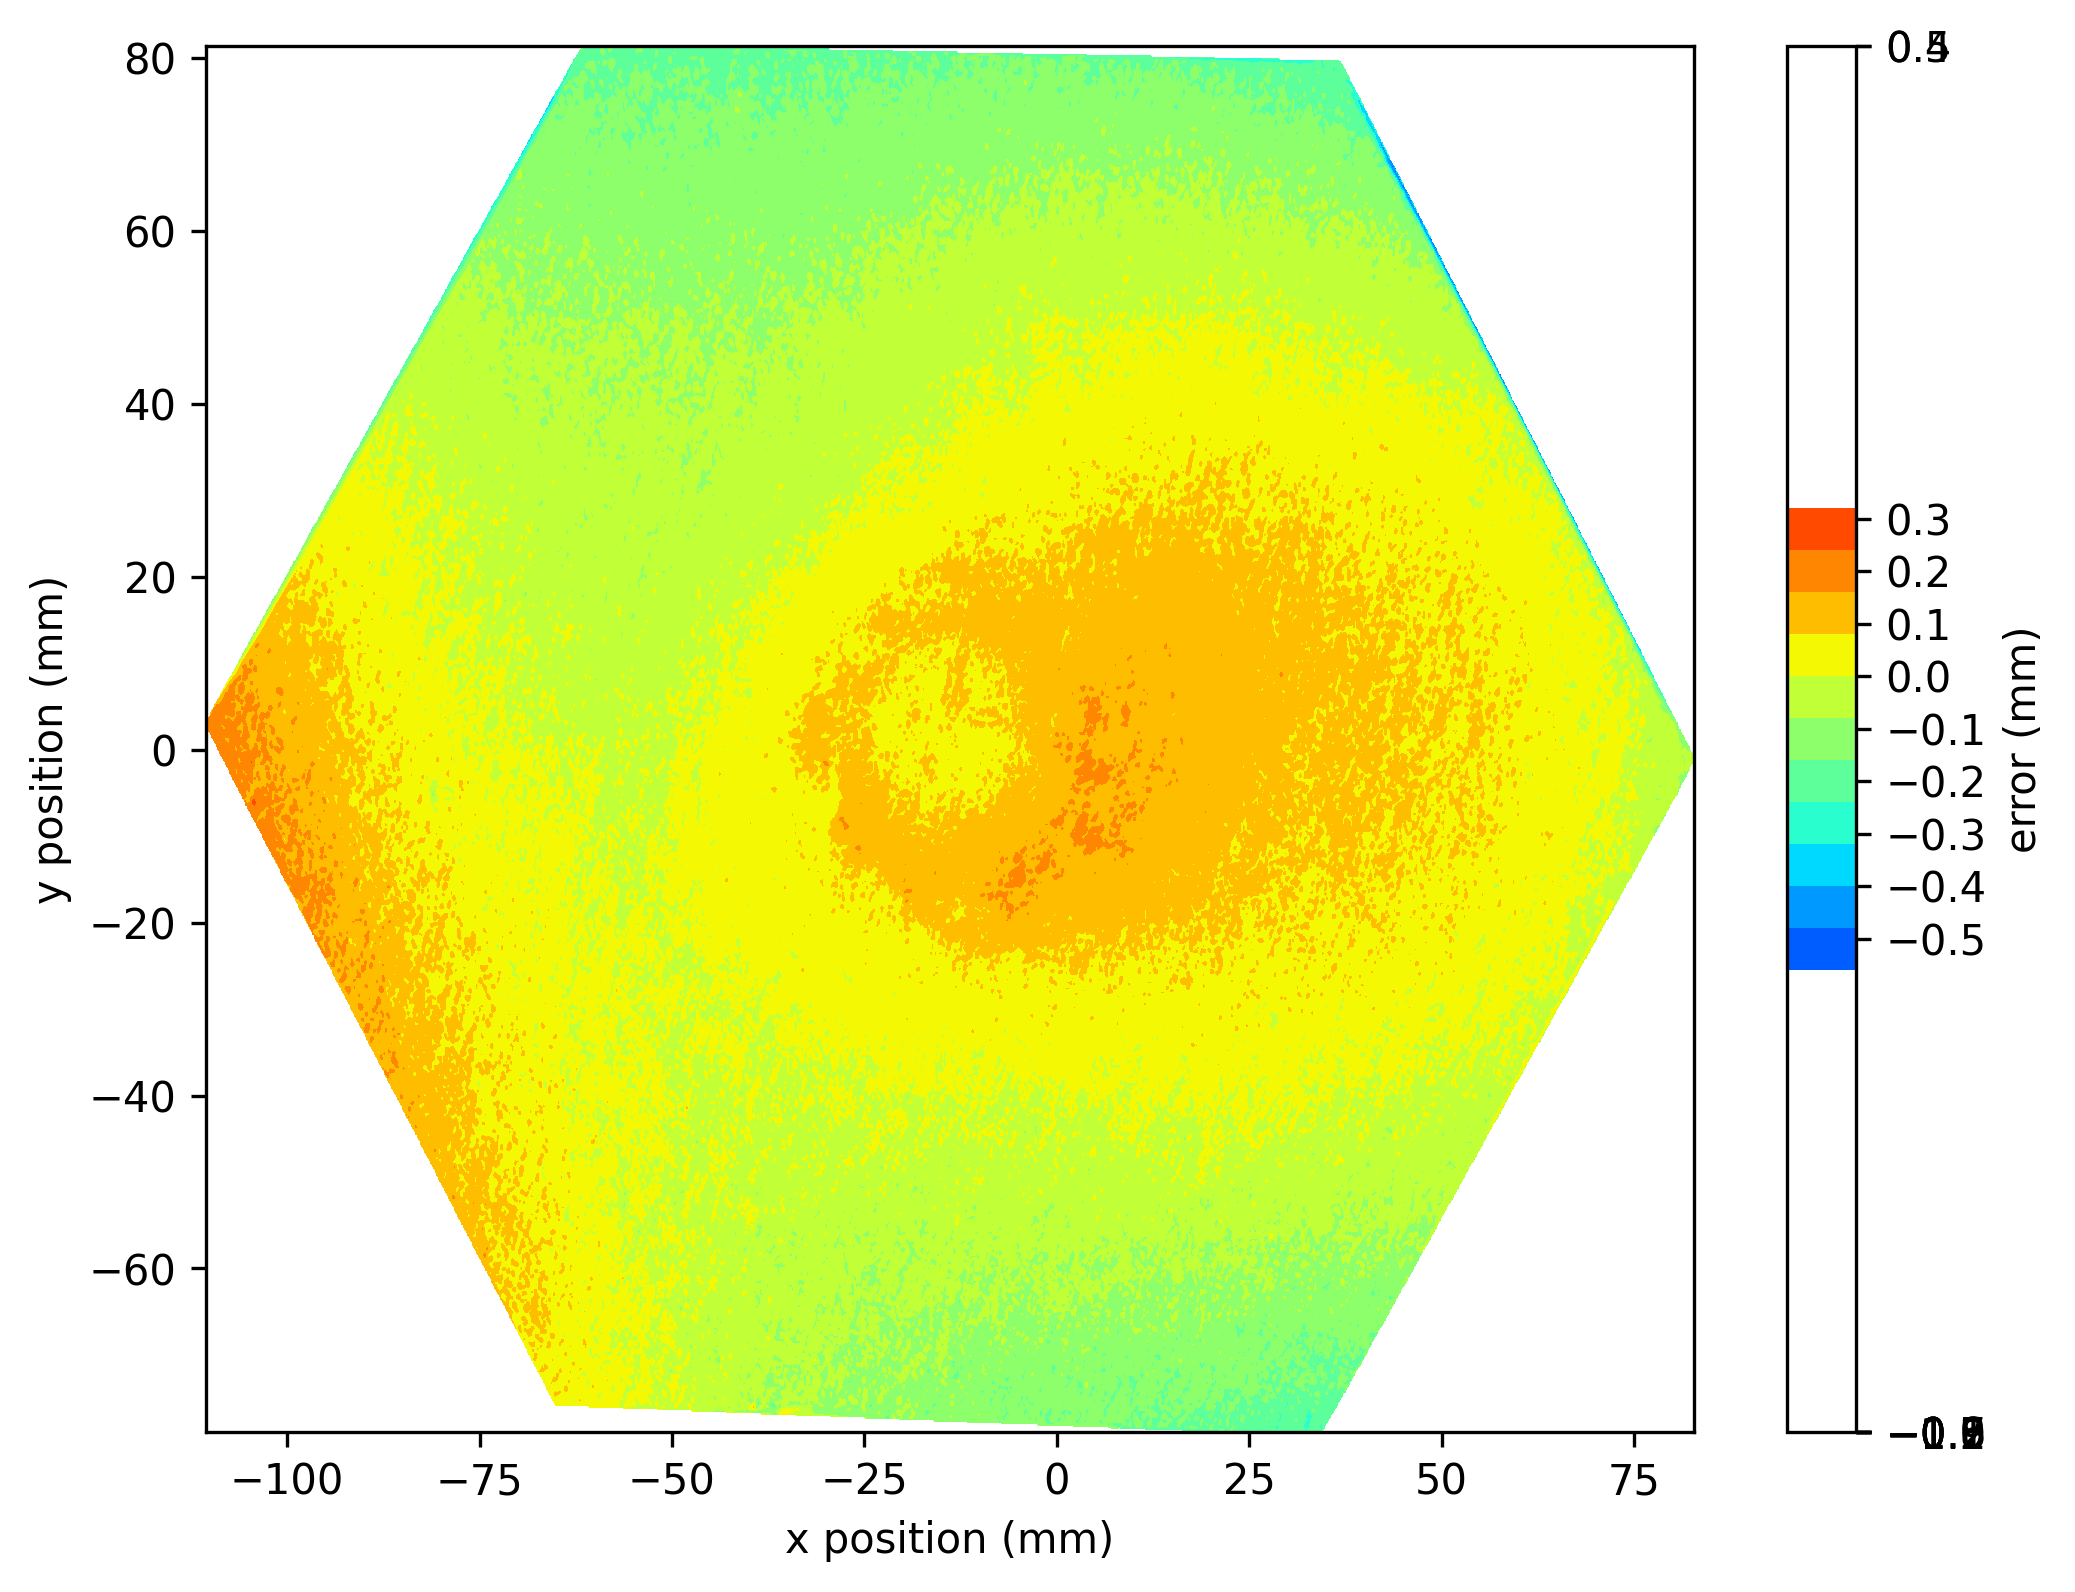

In [14]:
plt.figure(figsize=(8,6), dpi=300)
# contour the gridded data, plotting dots at the nonuniform data points.
CS = plt.contourf(xi,yi,zi,10,vmin=-0.8, vmax= 0.5, cmap=plt.cm.jet,extend='neither')
# add colorbar title
cbar = plt.colorbar()
cbar.ax.set_ylabel('error (mm)')
cbar.set_ticks([-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5])

plt.xlim(np.min(data[:,0]), np.max(data[:,0]))
plt.ylim(np.min(data[:,1]), np.max(data[:,1]))
plt.xlabel('x position (mm)')
plt.ylabel('y position (mm)')
plt.show